# Intro
Voy a hacer un proyecto basico basado en la competicion de Kaggle [Give Me Some Credit](https://www.kaggle.com/competitions/GiveMeSomeCredit/data) donde lo que buscamos es predecir la probabilidad de que alguien muestre estres financiero en los proximos dos años.

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load
Vamos a cargar los archivos que tenemos para ver siquiera que pinta tienen. Los archivos que venian acompañados de la competicion son:
    - rejected: Tenemos informacion sobre los creditos que fueron rechazados
    - acepted: Informacion sobre los creditos que fueron aceptados


In [2]:
df_test = pd.read_csv("../data/raw/cs-test.csv")
df_train = pd.read_csv("../data/raw/cs-training.csv")
data_dictionary = pd.read_excel("../data/raw/Data Dictionary.xlsx",sheet_name=0,header=1)

# EDA

## Target separation
Vamos a quedarnos por un lado con el target que es el vector de si la gente entro en riesgo, que es SeriousDlqin2yrs

In [3]:
y_train = df_train["SeriousDlqin2yrs"]
y_train

0         1
1         0
2         0
3         0
4         0
         ..
149995    0
149996    0
149997    0
149998    0
149999    0
Name: SeriousDlqin2yrs, Length: 150000, dtype: int64

## Variable description

In [4]:
print(data_dictionary.to_markdown())

|    | Variable Name                        | Description                                                                                                                                              | Type       |
|---:|:-------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------|:-----------|
|  0 | SeriousDlqin2yrs                     | Person experienced 90 days past due delinquency or worse                                                                                                 | Y/N        |
|  1 | RevolvingUtilizationOfUnsecuredLines | Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits | percentage |
|  2 | age                                  | Age of borrower in years                                                                          

## Some cleaning
Sacamos la columna que no sirve

In [5]:
df_train = df_train.drop("Unnamed: 0",axis=1)

## Describe

In [6]:
df_train.loc[:,df_train.columns != 'SeriousDlqin2yrs'].describe()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.000000,150000.000000,150000.000000,150000.000000,1.202690e+05,150000.000000,150000.000000,150000.000000,150000.000000,146076.000000
mean,6.048438,52.295207,0.421033,353.005076,6.670221e+03,8.452760,0.265973,1.018240,0.240387,0.757222
std,249.755371,14.771866,4.192781,2037.818523,1.438467e+04,5.145951,4.169304,1.129771,4.155179,1.115086
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.029867,41.000000,0.000000,0.175074,3.400000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,0.154181,52.000000,0.000000,0.366508,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,0.559046,63.000000,0.000000,0.868254,8.249000e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,50708.000000,109.000000,98.000000,329664.000000,3.008750e+06,58.000000,98.000000,54.000000,98.000000,20.000000


Chequemos nulos

In [24]:
df_train.isna().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

## Algunas distribuciones

### Clase a predecir

Veamos que tan desbalanceado esta el problema

<Axes: xlabel='SeriousDlqin2yrs'>

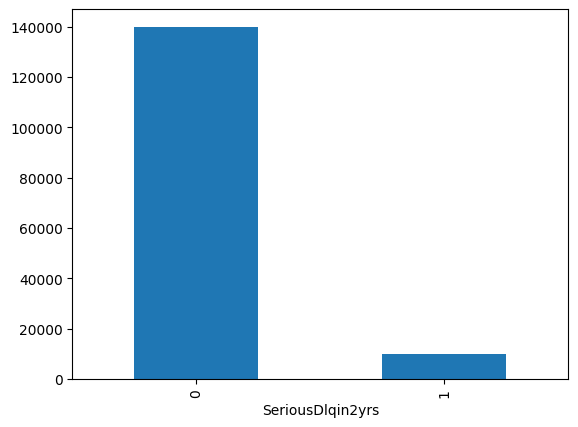

In [22]:
df_train.SeriousDlqin2yrs.value_counts().plot.bar()

<Axes: xlabel='SeriousDlqin2yrs'>

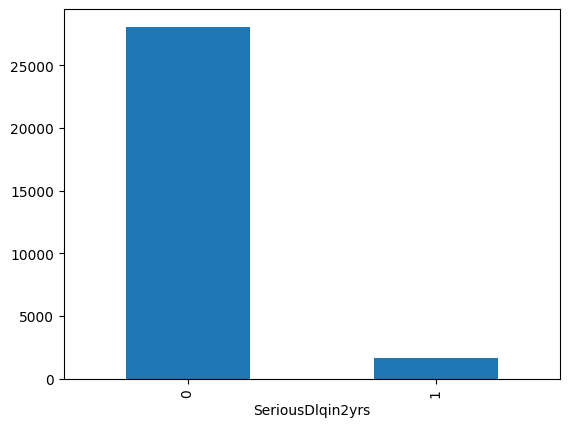

In [25]:
df_train[df_train["MonthlyIncome"].isna()].SeriousDlqin2yrs.value_counts().plot.bar()

La mayoria de los nullos corresponden a la clase que no defaulteo. Ahora bien, tienen algo en particular esos casos? Vamos algunos

In [26]:
df_train[df_train["MonthlyIncome"].isna()]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
6,0,0.305682,57,0,5710.0,NaN,8,0,3,0,0.0
8,0,0.116951,27,0,46.0,NaN,2,0,0,0,NaN
16,0,0.061086,78,0,2058.0,NaN,10,0,2,0,0.0
32,0,0.083418,62,0,977.0,NaN,6,0,1,0,0.0
41,0,0.072898,81,0,75.0,NaN,7,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
149976,0,0.000627,76,0,60.0,NaN,5,0,0,0,0.0
149977,0,0.236450,29,0,349.0,NaN,3,0,0,0,0.0
149984,0,0.037548,84,0,25.0,NaN,5,0,0,0,0.0
149992,0,0.871976,50,0,4132.0,NaN,11,0,1,0,3.0


<Axes: xlabel='SeriousDlqin2yrs'>

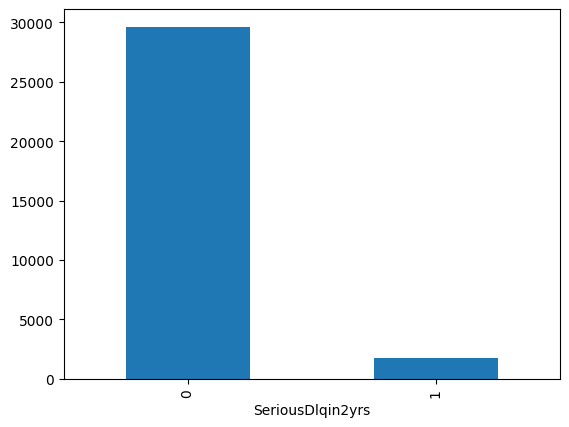

In [16]:
df_train[(df_train['MonthlyIncome']==0) | (df_train['MonthlyIncome'].isna()) ].SeriousDlqin2yrs.value_counts().plot.bar()

# Que variables estan correlacionadas?

<Axes: >

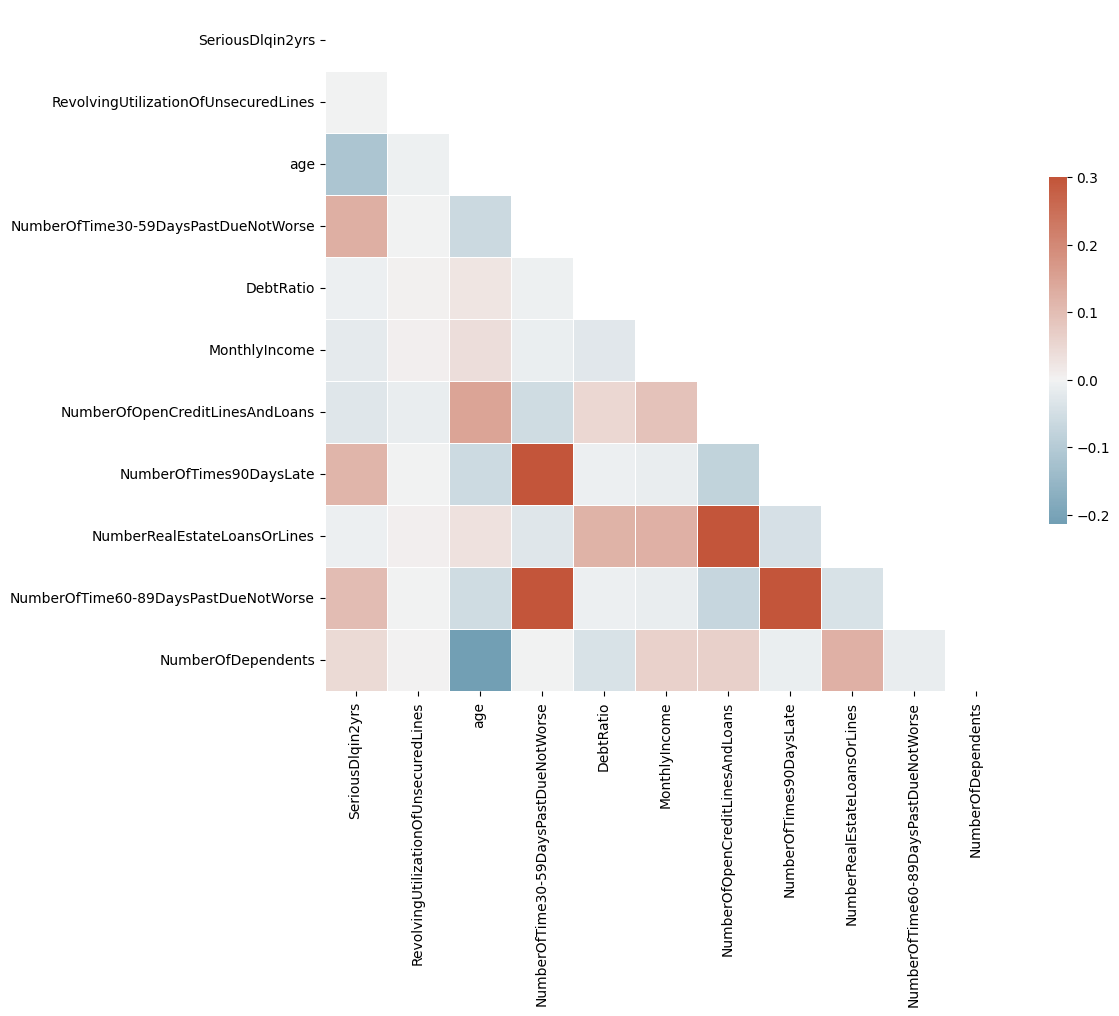

In [14]:
corr = df_train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})